![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Playing GridWorld with Reinforcement Learning (Policy Gradients with REINFORCE)

In this project we'll teach a neural network to navigate through a dangerous grid world.

![](http://i.imgur.com/XNGB7sr.gif)

Training uses [policy gradients](http://www.scholarpedia.org/article/Policy_gradient_methods) via the REINFORCE algorithm and a simplified Actor-Critic method. A single network calculates both a policy to choose the next action (the actor) and an estimated value of the current state (the critic). Rewards are propagated through the graph with PyTorch's [`reinforce` method](http://pytorch.org/docs/autograd.html?highlight=reinforce#torch.autograd.Variable.reinforce).

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
* [Scholarpedia article on policy gradient methods](http://www.scholarpedia.org/article/Policy_gradient_methods)
* [A Lecture from David Silver (of UCL, DeepMind) on policy gradients](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
* [The REINFORCE PyTorch example this tutorial is based on](https://github.com/pytorch/examples/tree/master/reinforcement_learning)


## Requirements

The main requirements are PyTorch (of course), and numpy, matplotlib, and iPython for animating the states.

In [1]:
import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
%pylab inline

from helpers import *

Populating the interactive namespace from numpy and matplotlib


/Users/sean/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## The Grid World, Agent and Environment

First we'll build the training environment, which is a simple square grid world with various rewards and a goal. If you're just interested in the training code, skip down to [building the actor-critic network](#Actor-Critic-network)

### The Grid

The **Grid** class keeps track of the grid world: a 2d array of empty squares, plants, and the goal.

![](https://i.imgur.com/kss8W95.png)

Plants are randomly placed values from -1 to 0.5 (mostly poisonous) and if the agent lands on one, that value is added to the agent's health. The agent's goal is to reach the goal square, placed in one of the corners. As the agent moves around it gradually loses health so it has to move with purpose.

The agent can see a surrounding area `VISIBLE_RADIUS` squares out from its position, so the edges of the grid are padded by that much with negative values. If the agent "falls off the edge" it dies instantly.

In [2]:
MIN_PLANT_VALUE = -1
MAX_PLANT_VALUE = 0.5
GOAL_VALUE = 10
EDGE_VALUE = -10
VISIBLE_RADIUS = 1

class Grid():
    def __init__(self, grid_size=8, n_plants=15):
        self.grid_size = grid_size
        self.n_plants = n_plants
        
    def reset(self):
        padded_size = self.grid_size + 2 * VISIBLE_RADIUS
        self.grid = np.zeros((padded_size, padded_size)) # Padding for edges
        
        # Edges
        self.grid[0:VISIBLE_RADIUS, :] = EDGE_VALUE
        self.grid[-1*VISIBLE_RADIUS:, :] = EDGE_VALUE
        self.grid[:, 0:VISIBLE_RADIUS] = EDGE_VALUE
        self.grid[:, -1*VISIBLE_RADIUS:] = EDGE_VALUE
        
        # Randomly placed plants
        for i in range(self.n_plants):
            plant_value = random.random() * (MAX_PLANT_VALUE - MIN_PLANT_VALUE) + MIN_PLANT_VALUE
            ry = random.randint(0, self.grid_size-1) + VISIBLE_RADIUS
            rx = random.randint(0, self.grid_size-1) + VISIBLE_RADIUS
            self.grid[ry, rx] = plant_value
 
        # Goal in one of the corners
        S = VISIBLE_RADIUS
        E = self.grid_size + VISIBLE_RADIUS - 1
        gps = [(E, E), (S, E), (E, S), (S, S)]
        gp = gps[random.randint(0, len(gps)-1)]
        self.grid[gp] = GOAL_VALUE
    
    def visible(self, pos):
        y, x = pos
        return self.grid[y-VISIBLE_RADIUS:y+VISIBLE_RADIUS+1, x-VISIBLE_RADIUS:x+VISIBLE_RADIUS+1]

### The Agent

The **Agent** has a current position and a health. All this class does is update the position based on an action (up, right, down or left) and decrement a small `STEP_VALUE` at every time step, so that it eventually starves if it doesn't reach the goal.

The world based effects on the agent's health are handled by the Environment below.

In [3]:
START_HEALTH = 1
STEP_VALUE = -0.02

class Agent:
    def reset(self):
        self.health = START_HEALTH

    def act(self, action):
        # Move according to action: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        y, x = self.pos
        if action == 0: y -= 1
        elif action == 1: x += 1
        elif action == 2: y += 1
        elif action == 3: x -= 1
        self.pos = (y, x)
        self.health += STEP_VALUE # Gradually getting hungrier

### The Environment

The **Environment** encapsulates the Grid and Agent, and handles the bulk of the logic of assigning rewards when the agent acts. If an agent lands on a plant or goal or edge, its health is updated accordingly. Plants are removed from the grid (set to 0) when "eaten" by the agent. Every time step there is also a slight negative health penalty so that the agent must keep finding plants or reach the goal to survive.

The Environment's main function is `step(action)` &rarr; `(state, reward, done)`, which updates the world state with a chosen action and returns the resulting state, and also returns a reward and whether the episode is done. The state it returns is what the agent will use to make its action predictions, which in this case is the visible grid area (flattened into one dimension) and the current agent health (to give it some "self awareness").

The episode is considered done if won or lost - won if the agent reaches the goal (`agent.health >= GOAL_VALUE`) and lost if the agent dies from falling off the edge, eating too many poisonous plants, or getting too hungry (`agent.health <= 0`).

In this experiment the environment only returns a single reward at the end of the episode (to make it more challenging). Values from plants and the step penalty are implicit - they might cause the agent to live longer or die sooner, but they aren't included in the final reward.

The Environment also keeps track of the grid and agent states for each step of an episode, for visualization.

In [4]:
class Environment:
    def __init__(self):
        self.grid = Grid()
        self.agent = Agent()

    def reset(self):
        """Start a new episode by resetting grid and agent"""
        self.grid.reset()
        self.agent.reset()
        c = math.floor(self.grid.grid_size / 2)
        self.agent.pos = (c, c)
        
        self.t = 0
        self.history = []
        self.record_step()
        
        return self.visible_state
    
    def record_step(self):
        """Add the current state to history for display later"""
        grid = np.array(self.grid.grid)
        grid[self.agent.pos] = self.agent.health * 0.5 # Agent marker faded by health
        visible = np.array(self.grid.visible(self.agent.pos))
        self.history.append((grid, visible, self.agent.health))
    
    @property
    def visible_state(self):
        """Return the visible area surrounding the agent, and current agent health"""
        visible = self.grid.visible(self.agent.pos)
        y, x = self.agent.pos
        yp = (y - VISIBLE_RADIUS) / self.grid.grid_size
        xp = (x - VISIBLE_RADIUS) / self.grid.grid_size
        extras = [self.agent.health, yp, xp]
        return np.concatenate((visible.flatten(), extras), 0)
    
    def step(self, action):
        """Update state (grid and agent) based on an action"""
        self.agent.act(action)
        
        # Get reward from where agent landed, add to agent health
        value = self.grid.grid[self.agent.pos]
        self.grid.grid[self.agent.pos] = 0
        self.agent.health += value
        
        # Check if agent won (reached the goal) or lost (health reached 0)
        won = value == GOAL_VALUE
        lost = self.agent.health <= 0
        done = won or lost
        
        # Rewards at end of episode
        if won:
            reward = 1
        elif lost:
            reward = -1
        else:
            reward = 0 # Reward will only come at the end

        # Save in history
        self.record_step()
        
        return self.visible_state, reward, done

### Visualizing History

To visualize an episode the `animate(history)` function uses Matplotlib to plot the grid state and agent health over time, and turn the resulting frames into a GIF.

In [5]:
def animate(history):
    frames = len(history)
    print("Rendering %d frames..." % frames)
    fig = plt.figure(figsize=(6, 2))
    fig_grid = fig.add_subplot(121)
    fig_health = fig.add_subplot(243)
    fig_visible = fig.add_subplot(244)
    fig_health.set_autoscale_on(False)
    health_plot = np.zeros((frames, 1))

    def render_frame(i):
        grid, visible, health = history[i]
        # Render grid
        fig_grid.matshow(grid, vmin=-1, vmax=1, cmap='jet')
        fig_visible.matshow(visible, vmin=-1, vmax=1, cmap='jet')
        # Render health chart
        health_plot[i] = health
        fig_health.clear()
        fig_health.axis([0, frames, 0, 2])
        fig_health.plot(health_plot[:i + 1])

    anim = matplotlib.animation.FuncAnimation(
        fig, render_frame, frames=frames, interval=100
    )

    plt.close()
    display(HTML(anim.to_html5_video()))

### Testing the Environment

Let's test what we have so far with a quick simulation:

In [6]:
env = Environment()
env.reset()
print(env.visible_state)

done = False
while not done:
    _, _, done = env.step(2) # Down

animate(env.history)

[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     1.     0.375
  0.375]
Rendering 6 frames...


## Actor-Critic network

Value-based reinforcement learning methods like Q-Learning try to predict the expected reward of the next state(s) given an action. In contrast, a policy method tries to directly choose the best action given a state. Policy methods are conceptually simpler but training can be tricky - due to the high variance of rewards, it can easily become unstable or just plateau at a local minimum.

Combining a value estimation with the policy helps regularize training by establishing a "baseline" reward that learns alongside the actor. Subtracting a baseline value from the rewards essentially trains the actor to perform "better than expected".

In this case, both actor and critic (baseline) are combined into a single neural network with 5 outputs: the probabilities of the 4 possible actions, and an estimated value.

The input layer `inp` transforms the environment state, $(radius*2+1)^2$ squares plus the agent's health and position,  into an internal state. The output layer `out` transforms that internal state to probabilities of possible actions plus the estimated value.

In [7]:
class Policy(nn.Module):
    def __init__(self, hidden_size):
        super(Policy, self).__init__()
        
        visible_squares = (VISIBLE_RADIUS * 2 + 1) ** 2
        input_size = visible_squares + 1 + 2 # Plus agent health, y, x
        
        self.inp = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, 4 + 1, bias=False) # For both action and expected value

    def forward(self, x):
        x = x.view(1, -1)
        x = F.tanh(x) # Squash inputs
        x = F.relu(self.inp(x))
        x = self.out(x)
        
        # Split last five outputs into scores and value
        scores = x[:,:4]
        value = x[:,4]
        return scores, value

## Selecting actions

To select actions we treat the output of the policy as a multinomial distribution over actions, and sample from that to choose a single action. Thanks to the [REINFORCE](https://webdocs.cs.ualberta.ca/~sutton/williams-92.pdf) algorithm we can calculate gradients for discrete action samples by calling `action.reinforce(reward)` at the end of the episode.

To encourage exploration in early episodes, here's one weird trick: apply dropout to the action scores, before softmax. Randomly masking some scores will cause less likely scores to be chosen. The dropout percent gradually decreases from 30% to 5% over the first 200k episodes.

In [8]:
DROP_MAX = 0.3
DROP_MIN = 0.05
DROP_OVER = 200000

def select_action(e, state):
    drop = interpolate(e, DROP_MAX, DROP_MIN, DROP_OVER)
    
    state = Variable(torch.from_numpy(state).float())
    scores, value = policy(state) # Forward state through network
    scores = F.dropout(scores, drop, True) # Dropout for exploration
    scores = F.softmax(scores)
    action = scores.multinomial() # Sample an action

    return action, value

## Playing through an episode

A single episode is the agent moving through the environment from start to finish. We keep track of the chosen action and value outputs from the model, and resulting rewards to reinforce at the end of the episode.

In [9]:
def run_episode(e):
    state = env.reset()
    actions = []
    values = []
    rewards = []
    done = False

    while not done:
        action, value = select_action(e, state)
        state, reward, done = env.step(action.data[0, 0])
        actions.append(action)
        values.append(value)
        rewards.append(reward)

    return actions, values, rewards

## Using REINFORCE with a value baseline

The policy gradient method is similar to regular supervised learning, except we don't know the "correct" action for any given state. Plus we are only getting a single reward at the end of the episode. To give rewards to past actions we fake history by copying the final reward (and possibly intermediate rewards) back in time with a discount factor:

![](https://i.imgur.com/IoXMuCb.png)

Then for every time step, we use `action.reinforce(reward)` to encourage or discourage those actions.

We will use the value output of the network as a baseline, and use the difference of the reward and the baseline with `reinforce`. The value estimate itself is trained to be close to the actual reward with a MSE loss.

In [10]:
gamma = 0.9 # Discounted reward factor

mse = nn.MSELoss()

def finish_episode(e, actions, values, rewards):
    
    # Calculate discounted rewards, going backwards from end
    discounted_rewards = []
    R = 0
    for r in rewards[::-1]:
        R = r + gamma * R
        discounted_rewards.insert(0, R)
    discounted_rewards = torch.Tensor(discounted_rewards)

    # Use REINFORCE on chosen actions and associated discounted rewards
    value_loss = 0
    for action, value, reward in zip(actions, values, discounted_rewards):
        reward_diff = reward - value.data[0] # Treat critic value as baseline
        action.reinforce(reward_diff) # Try to perform better than baseline
        value_loss += mse(value, Variable(torch.Tensor([reward]))) # Compare with actual reward

    # Backpropagate
    optimizer.zero_grad()
    nodes = [value_loss] + actions
    gradients = [torch.ones(1)] + [None for _ in actions] # No gradients for reinforced values
    autograd.backward(nodes, gradients)
    optimizer.step()
    
    return discounted_rewards, value_loss

With everything in place we can define the training parameters and create the actual Environment and Policy instances. We'll also use a SlidingAverage helper to keep track of average rewards over time.

In [11]:
hidden_size = 50
learning_rate = 1e-4
weight_decay = 1e-5

log_every = 1000
render_every = 20000

env = Environment()
policy = Policy(hidden_size=hidden_size)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)#, weight_decay=weight_decay)

reward_avg = SlidingAverage('reward avg', steps=log_every)
value_avg = SlidingAverage('value avg', steps=log_every)


Finally, we run a bunch of episodes and wait for some results. The average final reward will help us track whether it's learning. This took about an hour on a 2.8GHz CPU to get some reasonable results.

In [12]:
e = 0

while reward_avg < 0.75:
    actions, values, rewards = run_episode(e)
    final_reward = rewards[-1]
    
    discounted_rewards, value_loss = finish_episode(e, actions, values, rewards)
    
    reward_avg.add(final_reward)
    value_avg.add(value_loss.data[0])
    
    if e % log_every == 0:
        print('[epoch=%d]' % e, reward_avg, value_avg)
    
    if e > 0 and e % render_every == 0:
        animate(env.history)
    
    e += 1

[epoch=0] reward avg=-1.0000 value avg=5.6570
[epoch=1000] reward avg=-0.9740 value avg=2.7766
[epoch=2000] reward avg=-0.9600 value avg=1.5183
[epoch=3000] reward avg=-0.9420 value avg=1.5846
[epoch=4000] reward avg=-0.9640 value avg=1.4439
[epoch=5000] reward avg=-0.9420 value avg=1.5593
[epoch=6000] reward avg=-0.9360 value avg=1.7154
[epoch=7000] reward avg=-0.9240 value avg=1.8695
[epoch=8000] reward avg=-0.9180 value avg=1.9271
[epoch=9000] reward avg=-0.8700 value avg=2.2150
[epoch=10000] reward avg=-0.8620 value avg=2.2781
[epoch=11000] reward avg=-0.8320 value avg=2.5636
[epoch=12000] reward avg=-0.7760 value avg=2.6614
[epoch=13000] reward avg=-0.7640 value avg=2.7424
[epoch=14000] reward avg=-0.7060 value avg=2.8898
[epoch=15000] reward avg=-0.6620 value avg=3.1093
[epoch=16000] reward avg=-0.6300 value avg=3.0002
[epoch=17000] reward avg=-0.6100 value avg=3.0183
[epoch=18000] reward avg=-0.5580 value avg=3.0212
[epoch=19000] reward avg=-0.5680 value avg=2.9777
[epoch=20000]

[epoch=21000] reward avg=-0.4800 value avg=3.0787
[epoch=22000] reward avg=-0.4660 value avg=3.1405
[epoch=23000] reward avg=-0.3340 value avg=3.2157
[epoch=24000] reward avg=-0.4140 value avg=3.0677
[epoch=25000] reward avg=-0.2980 value avg=3.2760
[epoch=26000] reward avg=-0.3500 value avg=3.0733
[epoch=27000] reward avg=-0.3220 value avg=3.0263
[epoch=28000] reward avg=-0.3160 value avg=2.9758
[epoch=29000] reward avg=-0.3180 value avg=3.0533
[epoch=30000] reward avg=-0.2880 value avg=2.8530
[epoch=31000] reward avg=-0.2500 value avg=3.0794
[epoch=32000] reward avg=-0.2780 value avg=3.0500
[epoch=33000] reward avg=-0.3060 value avg=2.8212
[epoch=34000] reward avg=-0.2440 value avg=2.9480
[epoch=35000] reward avg=-0.1440 value avg=3.0938
[epoch=36000] reward avg=-0.2100 value avg=3.1951
[epoch=37000] reward avg=-0.1140 value avg=3.1707
[epoch=38000] reward avg=-0.2060 value avg=3.0702
[epoch=39000] reward avg=-0.1800 value avg=2.9726
[epoch=40000] reward avg=-0.1040 value avg=3.0987


[epoch=41000] reward avg=-0.2180 value avg=2.8552
[epoch=42000] reward avg=-0.1860 value avg=2.9884
[epoch=43000] reward avg=-0.1800 value avg=2.8004
[epoch=44000] reward avg=-0.1400 value avg=2.9231
[epoch=45000] reward avg=-0.1200 value avg=2.8050
[epoch=46000] reward avg=-0.1180 value avg=3.0405
[epoch=47000] reward avg=-0.1220 value avg=2.8643
[epoch=48000] reward avg=-0.0820 value avg=2.8232
[epoch=49000] reward avg=-0.0760 value avg=2.7912
[epoch=50000] reward avg=-0.1360 value avg=2.8212
[epoch=51000] reward avg=-0.1120 value avg=2.8823
[epoch=52000] reward avg=-0.0880 value avg=2.8519
[epoch=53000] reward avg=-0.0640 value avg=2.8911
[epoch=54000] reward avg=-0.0760 value avg=2.8220
[epoch=55000] reward avg=-0.1200 value avg=2.5774
[epoch=56000] reward avg=-0.1060 value avg=2.7156
[epoch=57000] reward avg=-0.0460 value avg=2.7477
[epoch=58000] reward avg=-0.0540 value avg=2.7149
[epoch=59000] reward avg=-0.0420 value avg=2.8103
[epoch=60000] reward avg=-0.0020 value avg=2.8103


[epoch=61000] reward avg=0.0140 value avg=2.8072
[epoch=62000] reward avg=0.0120 value avg=2.7167
[epoch=63000] reward avg=0.0100 value avg=2.7989
[epoch=64000] reward avg=-0.0340 value avg=2.6266
[epoch=65000] reward avg=-0.0780 value avg=2.4347
[epoch=66000] reward avg=-0.0680 value avg=2.6278
[epoch=67000] reward avg=-0.0480 value avg=2.5624
[epoch=68000] reward avg=-0.0540 value avg=2.4876
[epoch=69000] reward avg=-0.0120 value avg=2.5917
[epoch=70000] reward avg=-0.0160 value avg=2.5240
[epoch=71000] reward avg=-0.0800 value avg=2.3887
[epoch=72000] reward avg=0.0340 value avg=2.6404
[epoch=73000] reward avg=-0.0160 value avg=2.5540
[epoch=74000] reward avg=-0.0220 value avg=2.4573
[epoch=75000] reward avg=-0.0300 value avg=2.4484
[epoch=76000] reward avg=-0.0720 value avg=2.3868
[epoch=77000] reward avg=0.0160 value avg=2.5220
[epoch=78000] reward avg=-0.0520 value avg=2.5630
[epoch=79000] reward avg=0.0280 value avg=2.3931
[epoch=80000] reward avg=-0.0380 value avg=2.2635
Render

[epoch=81000] reward avg=0.0500 value avg=2.4029
[epoch=82000] reward avg=-0.0540 value avg=2.2796
[epoch=83000] reward avg=0.0160 value avg=2.3000
[epoch=84000] reward avg=-0.0380 value avg=2.3727
[epoch=85000] reward avg=0.0040 value avg=2.4260
[epoch=86000] reward avg=-0.0460 value avg=2.1574
[epoch=87000] reward avg=-0.0080 value avg=2.3031
[epoch=88000] reward avg=-0.0840 value avg=2.0344
[epoch=89000] reward avg=-0.0760 value avg=2.0799
[epoch=90000] reward avg=-0.0680 value avg=2.0726
[epoch=91000] reward avg=-0.0260 value avg=2.2026
[epoch=92000] reward avg=-0.0640 value avg=2.0950
[epoch=93000] reward avg=-0.0600 value avg=1.9660
[epoch=94000] reward avg=-0.1100 value avg=1.8462
[epoch=95000] reward avg=-0.0680 value avg=1.9794
[epoch=96000] reward avg=-0.0300 value avg=2.0902
[epoch=97000] reward avg=-0.0440 value avg=2.0968
[epoch=98000] reward avg=-0.0340 value avg=2.0948
[epoch=99000] reward avg=-0.0340 value avg=1.9508
[epoch=100000] reward avg=-0.0480 value avg=1.9128
Re

[epoch=101000] reward avg=-0.0200 value avg=1.8954
[epoch=102000] reward avg=-0.0080 value avg=2.0457
[epoch=103000] reward avg=-0.0360 value avg=2.0535
[epoch=104000] reward avg=-0.0520 value avg=1.9996
[epoch=105000] reward avg=0.0020 value avg=2.1378
[epoch=106000] reward avg=0.0340 value avg=2.1125
[epoch=107000] reward avg=0.0420 value avg=2.1620
[epoch=108000] reward avg=0.0400 value avg=2.2281
[epoch=109000] reward avg=0.0360 value avg=2.2380
[epoch=110000] reward avg=0.0000 value avg=2.1415
[epoch=111000] reward avg=0.0580 value avg=2.1649
[epoch=112000] reward avg=-0.0160 value avg=2.2506
[epoch=113000] reward avg=0.0120 value avg=2.2178
[epoch=114000] reward avg=-0.0360 value avg=1.8879
[epoch=115000] reward avg=0.0600 value avg=2.1395
[epoch=116000] reward avg=0.0060 value avg=2.1164
[epoch=117000] reward avg=-0.0400 value avg=1.9164
[epoch=118000] reward avg=-0.0160 value avg=1.8714
[epoch=119000] reward avg=0.0140 value avg=2.0096
[epoch=120000] reward avg=0.0360 value avg

[epoch=121000] reward avg=0.0660 value avg=2.0845
[epoch=122000] reward avg=0.0760 value avg=2.0736
[epoch=123000] reward avg=-0.0140 value avg=1.7696
[epoch=124000] reward avg=-0.1140 value avg=1.7106
[epoch=125000] reward avg=-0.1720 value avg=1.5944
[epoch=126000] reward avg=-0.2460 value avg=1.3580
[epoch=127000] reward avg=-0.0560 value avg=1.7342
[epoch=128000] reward avg=-0.0860 value avg=1.5200
[epoch=129000] reward avg=-0.1580 value avg=1.5148
[epoch=130000] reward avg=-0.1100 value avg=1.5950
[epoch=131000] reward avg=-0.1940 value avg=1.4144
[epoch=132000] reward avg=-0.2380 value avg=1.4147
[epoch=133000] reward avg=-0.1900 value avg=1.3975
[epoch=134000] reward avg=-0.2000 value avg=1.3473
[epoch=135000] reward avg=-0.2560 value avg=1.2985
[epoch=136000] reward avg=-0.1800 value avg=1.3935
[epoch=137000] reward avg=-0.2300 value avg=1.2835
[epoch=138000] reward avg=-0.2440 value avg=1.3503
[epoch=139000] reward avg=-0.2300 value avg=1.2931
[epoch=140000] reward avg=-0.2180

[epoch=141000] reward avg=-0.2580 value avg=1.2084
[epoch=142000] reward avg=-0.2340 value avg=1.2617
[epoch=143000] reward avg=-0.1680 value avg=1.3163
[epoch=144000] reward avg=-0.1480 value avg=1.3855
[epoch=145000] reward avg=-0.1720 value avg=1.2902
[epoch=146000] reward avg=-0.1840 value avg=1.3111
[epoch=147000] reward avg=-0.1320 value avg=1.3029
[epoch=148000] reward avg=-0.1760 value avg=1.2370
[epoch=149000] reward avg=-0.1800 value avg=1.3052
[epoch=150000] reward avg=-0.2460 value avg=1.2406
[epoch=151000] reward avg=-0.1580 value avg=1.2520
[epoch=152000] reward avg=-0.1240 value avg=1.3091
[epoch=153000] reward avg=-0.2140 value avg=1.1697
[epoch=154000] reward avg=-0.2220 value avg=1.2158
[epoch=155000] reward avg=-0.1260 value avg=1.3016
[epoch=156000] reward avg=-0.1500 value avg=1.2398
[epoch=157000] reward avg=-0.1260 value avg=1.2868
[epoch=158000] reward avg=-0.2060 value avg=1.2502
[epoch=159000] reward avg=-0.1500 value avg=1.2797
[epoch=160000] reward avg=-0.10

[epoch=161000] reward avg=-0.0940 value avg=1.2735
[epoch=162000] reward avg=-0.1060 value avg=1.3275
[epoch=163000] reward avg=-0.0540 value avg=1.3247
[epoch=164000] reward avg=0.1500 value avg=2.1876
[epoch=165000] reward avg=0.5620 value avg=2.5559
[epoch=166000] reward avg=0.6060 value avg=2.4327
[epoch=167000] reward avg=0.5480 value avg=2.2885
[epoch=168000] reward avg=0.5560 value avg=2.3068
[epoch=169000] reward avg=0.6060 value avg=2.1906
[epoch=170000] reward avg=0.5940 value avg=2.1082
[epoch=171000] reward avg=0.5860 value avg=2.1375
[epoch=172000] reward avg=0.5660 value avg=2.1844
[epoch=173000] reward avg=0.6360 value avg=1.9815
[epoch=174000] reward avg=0.6700 value avg=1.9800
[epoch=175000] reward avg=0.6340 value avg=2.0020
[epoch=176000] reward avg=0.7060 value avg=1.8904


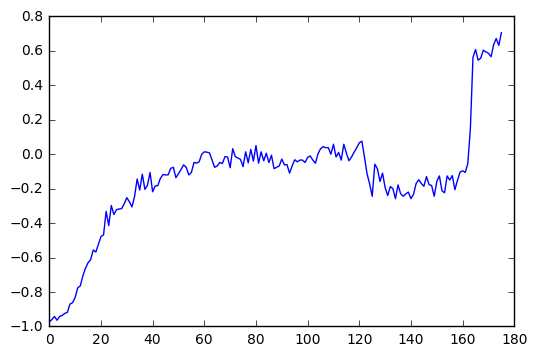

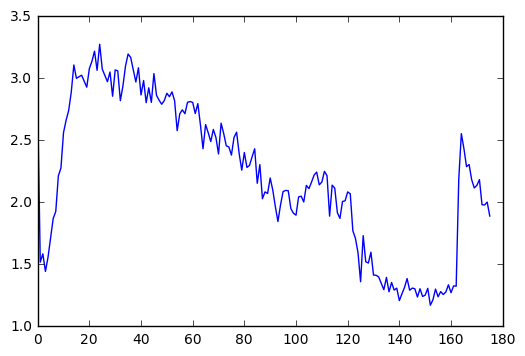

In [13]:
# Plot average reward and value loss
plt.plot(np.array(reward_avg.avgs))
plt.show()
plt.plot(np.array(value_avg.avgs))
plt.show()

As you can see from the shape of the rewards graph, training these kinds of networks is a rollercoaster of luck.

## Exercises

* Uncomment the line in the Environment class that returns a reward every step - the agent tends learn a bit quicker because the effects of eating plants are more immediately rewarded.
* Try with a bigger grid size, bigger visible area, bigger network, etc.
* Try with a recurrent network - it will train slower (in clock time) but often reaches higher values in fewer episodes.
* Observe the effects of different learning rates and gamma values.